# Downloading Library

In [1]:
!pip install transformers datasets -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 671.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 33.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.0
    Uninstalling transformers-4.44.0:
      Successfully uninstalled transformers-4.44.0


# Loading Library

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import torch
import seaborn as sns
import matplotlib.pyplot as plt

import re, string
from nltk.corpus import stopwords

# Loading Data

## https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews

In [3]:
data = pd.read_csv('/kaggle/input/arabic-100k-reviews/ar_reviews_100k.tsv', sep="\t")
data.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [4]:
data.isnull().sum()

label    0
text     0
dtype: int64

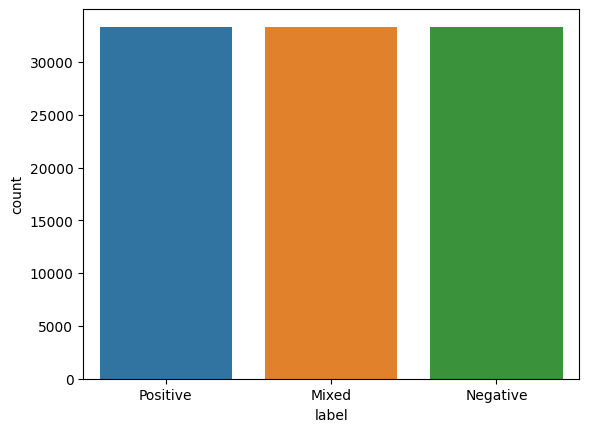

In [5]:
sns.countplot(x='label', data=data)
plt.show()

# Preprocessing In Data

In [7]:
punc = string.punctuation
sw = stopwords.words("arabic")

In [8]:
def preprocess(text):
#     text = text.lower()
    text = text.split()
    text = ' '.join([word for word in text if (word not in sw) and (word not in punc)])
    return text

In [9]:
data.head(2)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...


In [10]:
data['text'] = data['text'].apply(preprocess)

In [12]:
data.head()

,label,text
0,Positive,ممتاز نوعا النظافة والموقع والتجهيز والشاطيء. ...
1,Positive,أسباب نجاح الإمارات شخص الدولة يعشق ترابها. نح...
2,Positive,هادفة .. وقوية. تنقلك صخب شوارع القاهرة الى هد...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء يتجزأ دبي فندق متكامل الخدمات...


# Label Encoder

In [22]:
data.loc[data["label"] == "Positive", "label"] = 0
data.loc[data["label"] == "Negative", "label"] = 1
data.loc[data["label"] == "Mixed", "label"] = 2

In [24]:
data.head()

,label,text
0,0,ممتاز نوعا النظافة والموقع والتجهيز والشاطيء. ...
1,0,أسباب نجاح الإمارات شخص الدولة يعشق ترابها. نح...
2,0,هادفة .. وقوية. تنقلك صخب شوارع القاهرة الى هد...
3,0,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,0,ياسات جلوريا جزء يتجزأ دبي فندق متكامل الخدمات...


# Start Using Transformers

## transform data into dataloader

In [25]:
new_data = Dataset.from_pandas(data)
new_data = new_data.train_test_split(train_size=0.8)
new_data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 79999
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 20000
    })
})

In [26]:
new_data['train'][0]

{'label': 0,
 'text': 'جيد جدا. حجم الغرفه وتعاون موظف الاستقبال. نسيت احضار بطاقة البنك قمت بالحجز عليها موقع بوكينج أنه تم خصم مبلغ الحجز طلب مني استخدام بطاقه اخرى كانت معي ان يرد المبلغ خصم للبطاقه ولى مضى يوم ولم يرد المبلغ'}

## Download Tokenizer & Model

In [27]:
# model_name = 'distilbert-base-uncased'
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Apply Toknization

In [28]:
def token(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length')

In [29]:
tokenized_datasets = new_data.map(token, batched=True)

Map:   0%|          | 0/79999 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 79999
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
})

## Arguments

In [31]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10000,
)

In [32]:
def compute_metrics(p):
    pred, label = p
    pred = pred.argmax(axis=1)
    return {'Accuracy': (pred == label).mean()}

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    )

# Train The model

In [34]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
1000,0.821000
2000,0.703800
3000,0.673600
4000,0.662600
5000,0.643600
6000,0.554400


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 925814080 vs 925813972

In [25]:
trainer.evaluate(tokenized_datasets['test'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.6250662803649902,
 'eval_Accuracy': 0.655,
 'eval_runtime': 1.9051,
 'eval_samples_per_second': 104.98,
 'eval_steps_per_second': 3.674,
 'epoch': 2.0}

In [39]:
prediction = trainer.predict(tokenized_datasets['test'])[1]
prediction

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0])

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(tokenized_datasets['test']['label'], prediction)
acc = accuracy_score(tokenized_datasets['test']['label'], prediction)

print('THe Accuracy Of Testing Data is ---> ', acc*100)
cm

THe Accuracy Of Testing Data is --->  100.0


array([[103,   0],
       [  0,  97]])